# Recurrent Neural Network

## Part 0 - Get the data

In [100]:
import yfinance as yf #docs at https://pypi.org/project/yfinance/

In [136]:
#get the data
stock = "BTC-USD"
period = "1d" # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max ( default '1mo')
interval = "5m" # 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo (default '1d')
data = yf.download(tickers=stock, period = period, interval = interval)

[*********************100%***********************]  1 of 1 completed


In [137]:
#save it
data.to_csv("../data/yf_"+"_".join([stock,period,interval]))

## Part 1 - Data Preprocessing

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importing the training set

In [176]:
#Load data
#stock = "BTC-USD"
#period = "1d" 
#interval = "1m" 
#dataset_location = "../data/yf_"+"_".join([stock,period,interval])
#dataset = pd.read_csv(dataset_location, index_col = "Datetime", parse_dates = ["Datetime"])
dataset = pd.read_csv("../data/btc-usdt_1m.csv", index_col = "Date", parse_dates = ["Date"])
#split into training and test sets
num_records = dataset.shape[0]
test_size = min(int(num_records*0.2), 1000) #limits max number of test records
train_size = num_records - test_size
dataset_train = dataset.iloc[:train_size]
dataset_test = dataset.iloc[train_size:]
dataset_test

,Open,High,Low,Close,Volume
Date,,,,,
2022-09-17 12:28:00,19850.1,20091.7,19850.0,19850.1,36.404
2022-09-17 12:29:00,19850.1,20090.0,19850.1,19850.1,28.577
2022-09-17 12:30:00,19855.6,20092.0,19850.0,19852.9,131.046
2022-09-17 12:31:00,19886.1,20092.0,19850.0,19850.2,40.902
2022-09-17 12:32:00,19850.2,20091.7,19850.0,20091.6,62.320
...,...,...,...,...,...
2022-09-18 05:03:00,20228.8,20320.0,20220.0,20227.0,45.804
2022-09-18 05:04:00,20267.1,20320.0,20186.0,20196.3,100.617
2022-09-18 05:05:00,20221.5,20320.0,20186.0,20186.0,51.793


In [148]:
cols = ["Open", "Volume"] #cols to use (the first has to be the predicted one)
training_set = dataset_train[cols].loc[:].values
training_set


array([[21560.   ,    81.565],
       [21555.1  ,    41.665],
       [21548.   ,    33.66 ],
       ...,
       [19850.2  ,    98.354],
       [19851.2  ,   128.869],
       [19891.6  ,    26.129]])

### Feature Scaling

In [188]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.61291839, 0.07298036],
       [0.61127337, 0.03727761],
       [0.60888978, 0.03011469],
       ...,
       [0.03890959, 0.08800325],
       [0.03924531, 0.11530825],
       [0.05280827, 0.02337591]])

### Creating a data structure with 60 timesteps and 1 output

In [190]:
X_train = []
y_train = []
records = training_set_scaled.shape[0]
for i in range(60, records):
    X_train.append(training_set_scaled[i-60:i])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train) 
print(y_train[0])

[[[0.61291839 0.07298036]
  [0.61127337 0.03727761]
  [0.60888978 0.03011469]
  ...
  [0.62601135 0.05628328]
  [0.62567563 0.11165923]
  [0.62295632 0.03656803]]

 [[0.61127337 0.03727761]
  [0.60888978 0.03011469]
  [0.61600698 0.06106512]
  ...
  [0.62567563 0.11165923]
  [0.62295632 0.03656803]
  [0.62473562 0.05263874]]

 [[0.60888978 0.03011469]
  [0.61600698 0.06106512]
  [0.61778628 0.05985087]
  ...
  [0.62295632 0.03656803]
  [0.62473562 0.05263874]
  [0.62527277 0.0290445 ]]

 ...

 [[0.0966529  0.02058322]
  [0.072817   0.05016549]
  [0.06063048 0.00846128]
  ...
  [0.03884245 0.07704546]
  [0.03884245 0.06380054]
  [0.03884245 0.05244546]]

 [[0.072817   0.05016549]
  [0.06063048 0.00846128]
  [0.08601068 0.04419267]
  ...
  [0.03884245 0.06380054]
  [0.03884245 0.05244546]
  [0.03890959 0.08800325]]

 [[0.06063048 0.00846128]
  [0.08601068 0.04419267]
  [0.05401685 0.01973136]
  ...
  [0.03884245 0.05244546]
  [0.03890959 0.08800325]
  [0.03924531 0.11530825]]]
0.62473562

### Reshaping

In [151]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [192]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [193]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [194]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [195]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [196]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [197]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [198]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [199]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [200]:
regressor.fit(X_train, y_train, epochs = 5, batch_size = 64)

Epoch 1/5
141/141 [==============================] - 103s 591ms/step - loss: 0.0103
Epoch 2/5
141/141 [==============================] - 67s 472ms/step - loss: 0.0037
Epoch 3/5
141/141 [==============================] - 81s 574ms/step - loss: 0.0032
Epoch 4/5
141/141 [==============================] - 94s 662ms/step - loss: 0.0030
Epoch 5/5
141/141 [==============================] - 78s 553ms/step - loss: 0.0029


In [202]:
regressor.save('rnn.h5')
#load model
#regressor = keras.models.load_model('rnn.h5')

## Part 3 - Making the predictions and visualising the results

### Getting the predicted stock price

In [233]:
#concatenate all data to have all values
dataset_total = pd.concat((dataset_train[cols], dataset_test[cols]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
#inputs = inputs.reshape(-1, len(cols))
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i])
X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
#concatenate a columns of zeroes to inverse transform
predicted_stock_price = np.concatenate((predicted_stock_price, np.zeros((1000,1))), axis=1) #inverse transform needs same dimensions
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#return to one column
predicted_stock_price = np.delete(predicted_stock_price, np.s_[1::], 1)

32/32 [==============================] - 4s 114ms/step


In [242]:
real_stock_price = dataset_test[cols[0]].loc[:].values
real_stock_price

array([19850.1, 19850.1, 19855.6, 19886.1, 19850.2, 19906.1, 19918.3,
       20054.6, 20085.3, 19864.4, 19862.2, 19898.4, 19930. , 19930. ,
       19952.4, 20015.7, 20029. , 20015.8, 20028.6, 19856.9, 19929.6,
       19999.4, 20050.3, 19963.6, 20027.8, 19867.3, 20124. , 20038.3,
       20019.7, 20061.6, 20056.2, 20045. , 20109.9, 20112.9, 20116. ,
       19979.7, 20065.6, 20092.1, 20087.6, 19861.3, 19862.5, 19944. ,
       19897.1, 19969.7, 19903.1, 19939.7, 19988. , 20037.5, 20031.7,
       20014.7, 20002.9, 20006.3, 20014.5, 19981.2, 20031.8, 19954.6,
       19954.6, 19914.7, 19870.2, 19919.7, 20027.9, 19871.2, 19871.6,
       19871.6, 19877.2, 19878.8, 19909. , 19902.9, 19960.8, 19924. ,
       19902.8, 19914. , 19924.6, 19884.6, 19984.1, 19880. , 19889.9,
       19885. , 19885. , 19903.1, 19925.7, 19951.1, 19950.7, 19958.3,
       19881.8, 19878.5, 19879.7, 19876.2, 19947.5, 19927.4, 19942. ,
       19900.9, 19902.4, 19905. , 19915.4, 19925.9, 19968.5, 19976.3,
       19981.2, 1996

### Visualising the results

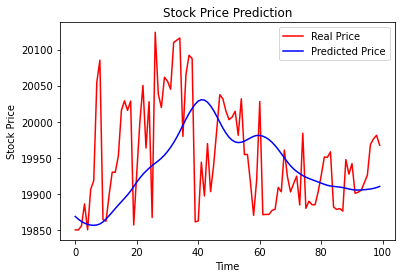

In [243]:
plt.plot(real_stock_price[0:100], color = 'red', label = 'Real Price')
plt.plot(predicted_stock_price[0:100], color = 'blue', label = 'Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()